In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
import dsn.lib.LowRank.Fig1_Spontaneous.fct_mf as mf
from dsn.util.systems import LowRankRNN
from dsn.util.tf_DMFT_solvers import rank2_CDD_static_solve
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints


DTYPE = tf.float64

# multivariate normal initialization variance
sigma_init = 2.0

basedir = '/Users/sbittner/Documents/dsn/dsn/'
dirstr = 'LowRankRNN'

# create an instance of the LowRankRNN system class
fixed_params = {'g':0.8, 'gammaLO':-0.14, 'gammaHI':0.08}

behavior_type = "CDD"
means = np.array([0.3])
variances = np.array([0.0001])
    
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':2, 'input_type':'input'}

solve_its = 500
solve_eps = 0.2

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)


# normalizing flow layer architecture
TIF_flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'D':system.D, \
             'latent_dynamics':None, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers}

c_init_order = 2
lr_order = -3
random_seed = 1

dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
fname = dsndir + 'opt_info.npz'
npzfile = np.load(fname)

Z = npzfile['Zs']

print(Z.shape)
n = Z.shape[1]

alpha = 0.05
frac_samps = 0.2
k_max = Z.shape[0]-1
pvalues, AL_final_its = assess_constraints([fname], alpha, frac_samps, k_max, system.num_suff_stats)

ind = AL_final_its[0]

_rhom = Z[ind,:,0]
_rhon = Z[ind,:,1]
_betam = Z[ind,:,2]
_betan = Z[ind,:,3]



(21, 1000, 4)


In [3]:
kappa1_init = tf.placeholder(dtype=DTYPE, shape=(n,))
kappa2_init = tf.placeholder(dtype=DTYPE, shape=(n,))
delta_0_init = tf.placeholder(dtype=DTYPE, shape=(n,))
delta_inf_init = tf.placeholder(dtype=DTYPE, shape=(n,))

g = tf.placeholder(dtype=DTYPE, shape=(n,))
rhom = tf.placeholder(dtype=DTYPE, shape=(n,))
rhon = tf.placeholder(dtype=DTYPE, shape=(n,))
betam = tf.placeholder(dtype=DTYPE, shape=(n,))
betan = tf.placeholder(dtype=DTYPE, shape=(n,))

its = 500
eps_list  = [0.2]

gqp = 50

## context A

In [4]:
cAs = [0, 1]
cBs = [0, 1]
kappa_sign = -1

_g = 0.8*np.ones((n,))
_delta_0_init = 10.0*np.ones((n,))
_kappa1_init = kappa_sign*2.2*np.ones((n,))
_kappa2_init = kappa_sign*2.0*np.ones((n,))

num_cAs = len(cAs)
num_cBs = len(cBs)
num_eps = len(eps_list)
gammaA = 0.08*np.ones((n,))
gammaB = -0.14*np.ones((n,))

kappa1s = np.zeros((num_eps, num_cAs,num_cBs,n,its+1))
kappa2s = np.zeros((num_eps, num_cAs,num_cBs,n,its+1))
delta_0s = np.zeros((num_eps, num_cAs,num_cBs,n,its+1))
zs = np.zeros((num_eps, num_cAs,num_cBs,n))

for ii in range(num_eps):
    eps = eps_list[ii]
    for i in range(num_cAs):
        cA = cAs[i]
        for j in range(num_cBs):
            cB = cBs[j]
            print('cA=%d' % cA, 'cB=%d' % cB)
            start_time = time.time()
            kappa1, kappa2, delta_0, z, xs = rank2_CDD_static_solve(kappa1_init, kappa2_init, delta_0_init, \
                                                             cA, cB, \
                                                             g, rhom, rhon, betam, betan, \
                                                             gammaA, gammaB, \
                                                             its, eps, gauss_quad_pts=gqp, db=True)

            feed_dict = {kappa1_init:_kappa1_init, kappa2_init:_kappa2_init, delta_0_init:_delta_0_init, \
                         g:_g, rhom:_rhom, rhon:_rhon, betam:_betam, betan:_betan}

            with tf.Session() as sess:
                _kappa1, _kappa2, _delta_0, _z, _xs = sess.run([kappa1, kappa2, delta_0, z, xs], feed_dict)
            print('took %f seconds' % (time.time() - start_time))
            kappa1s[ii,i,j] = _xs[:,0,:]
            kappa2s[ii,i,j] = _xs[:,1,:]
            delta_0s[ii,i,j] = _xs[:,2,:]
            zs[ii,i,j,:] = _z


cA=0 cB=0
took 66.293874 seconds
cA=0 cB=1
took 68.016560 seconds
cA=1 cB=0
took 68.969813 seconds
cA=1 cB=1
took 79.899629 seconds


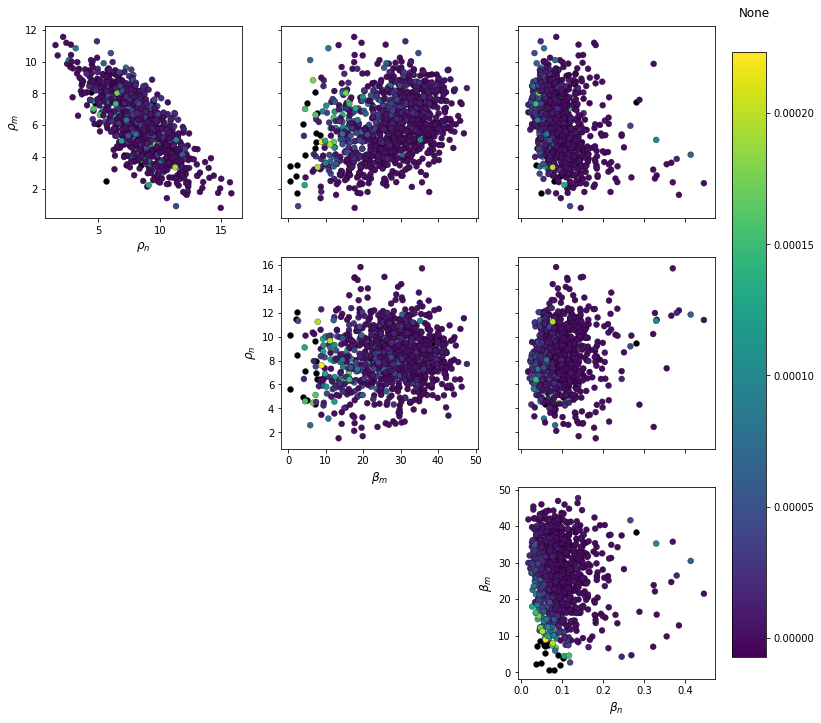

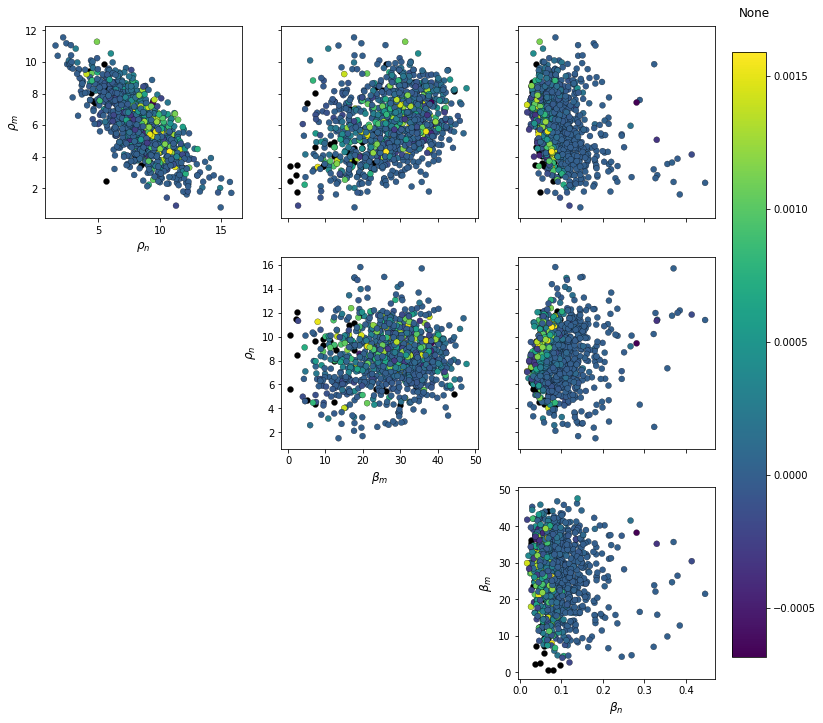

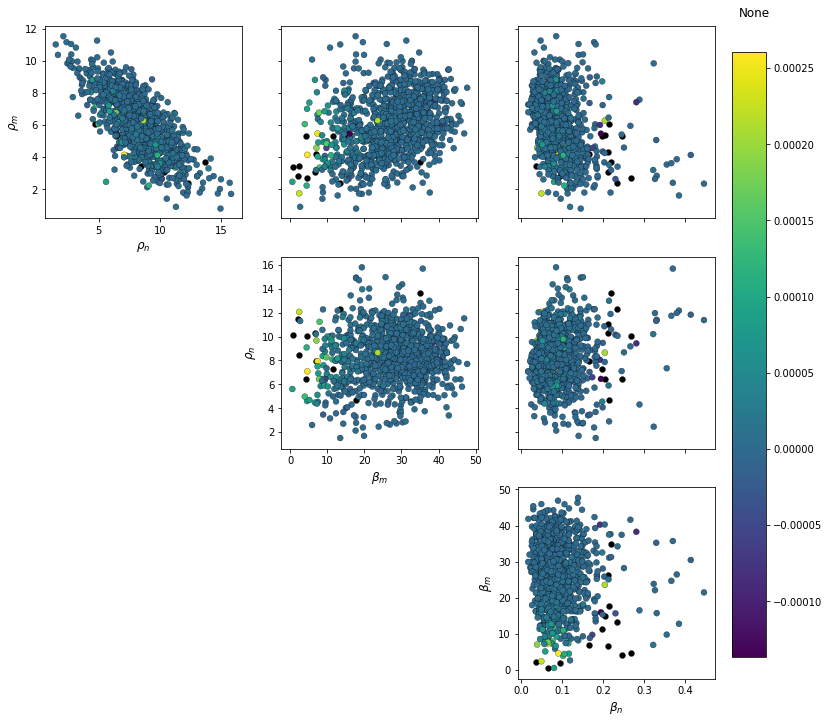

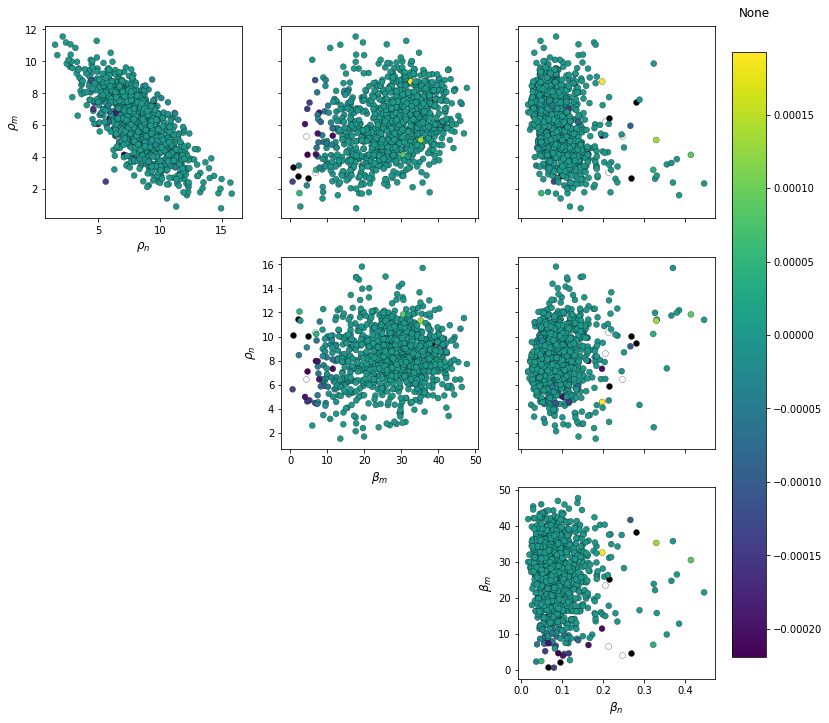

In [5]:
from dsn.util.plot_util import pairplot

labels = [r"$\rho_m$", r"$\rho_n$", r"$\beta_m$", r"$\beta_n$"]
                 
num_its = 500
params = np.stack([_rhom, _rhon, _betam, _betan], axis=1)
kappa1_diffs = kappa1s[:,:,:,:,num_its] - kappa1s[:,:,:,:,num_its-1]
kappa2_diffs = kappa2s[:,:,:,:,num_its] - kappa2s[:,:,:,:,num_its-1]
de1ta_0_diffs = delta_0s[:,:,:,:,num_its] - delta_0s[:,:,:,:,num_its-1]
z_diffs = zs[:,:,:,-1] - zs[:,:,:,-2]

inds = range(n)
#inds = np.logical_and(_betam < 0.2, _betan > 0.2)
#inds = np.logical_and(inds, np.logical_and(_rhom > 0.0, _rhon > 0.0))
#inds = np.logical_and(inds, _rhon < 2.0)
#inds = np.logical_and(inds, _betam > 0.0)
for i in range(2):
    for j in range(2):
        fig = pairplot(params[inds,:], range(4), c=kappa1_diffs[0,i,j,inds], labels=labels)

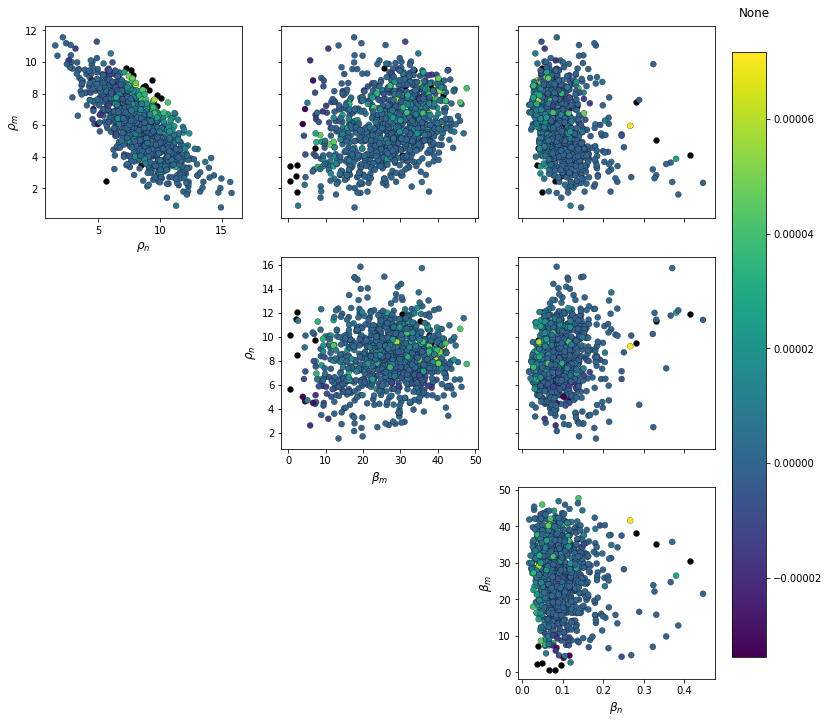

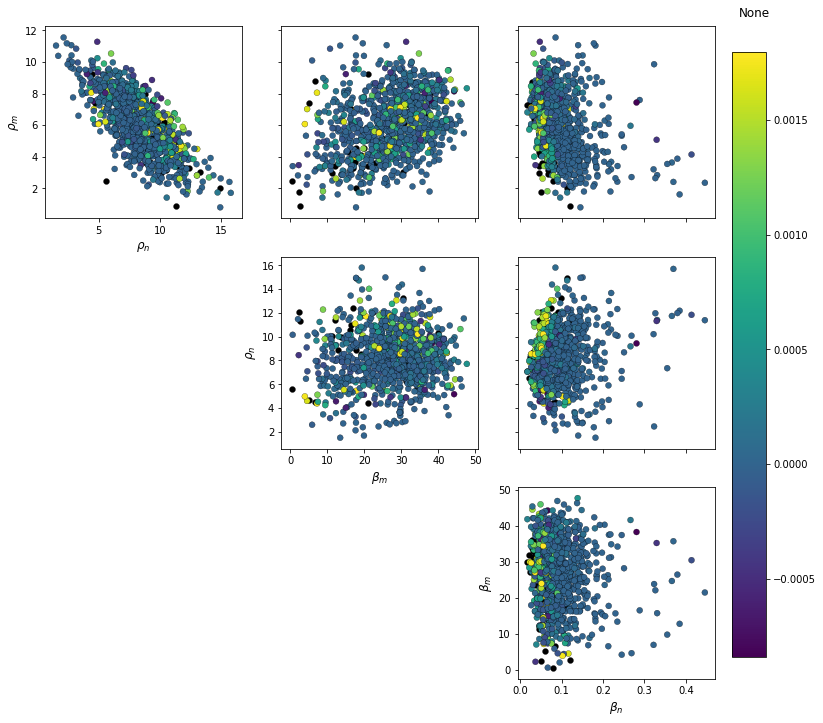

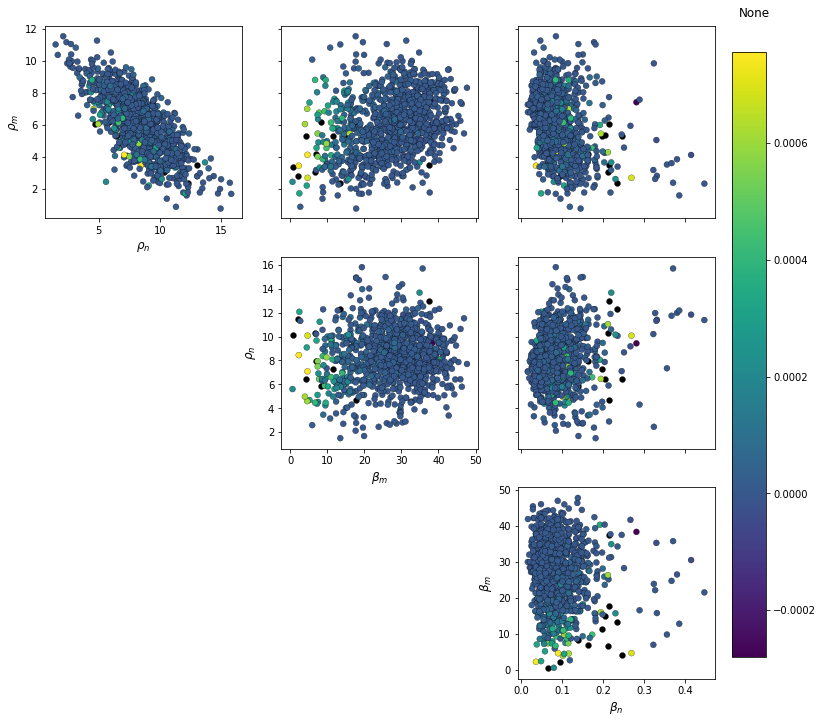

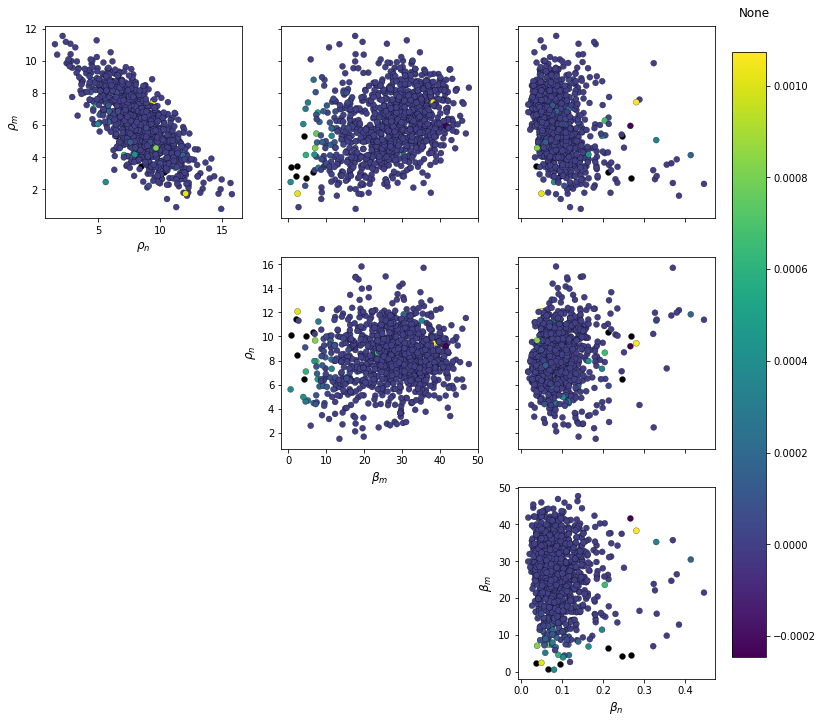

In [10]:
for i in range(2):
    for j in range(2):
        fig = pairplot(params[inds,:], range(4), c=kappa2_diffs[0,i,j,inds], labels=labels)

[5.32595925 6.45884864 4.23848127 0.24528083]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


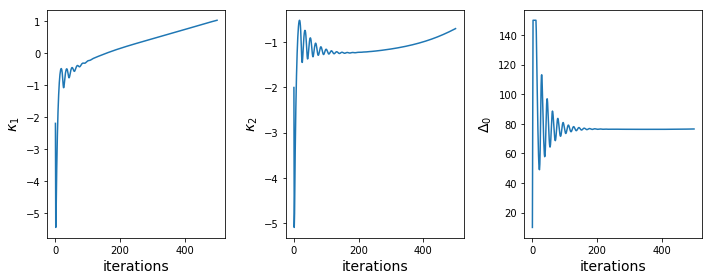

[4.17098026 7.96007414 6.87972967 0.16431718]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


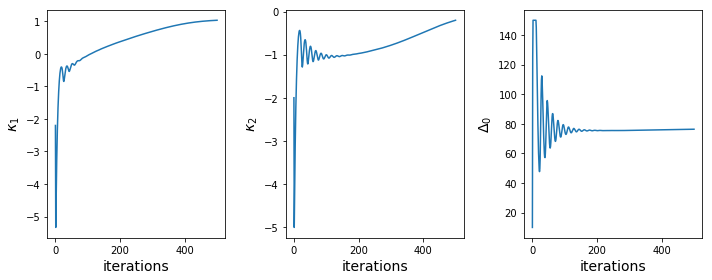

[ 2.41175349 12.32676452 13.40203791  0.2346946 ]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


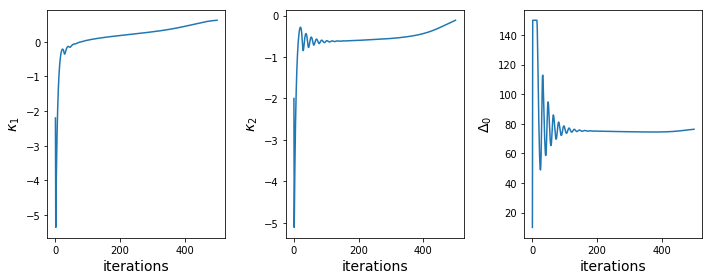

[7.0184085  4.60040806 4.54574155 0.11652606]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


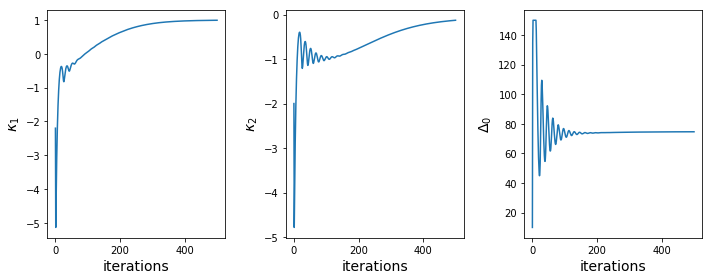

[ 5.47059137  6.45639197 15.99201597  0.19468257]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


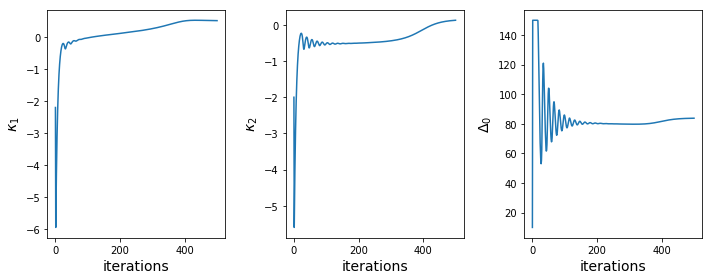

[ 6.07651699  4.68112804 17.77926593  0.21382163]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


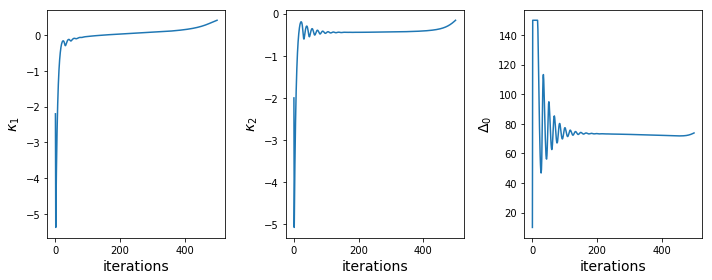

[6.20066509 5.85199806 8.2169472  0.13927577]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


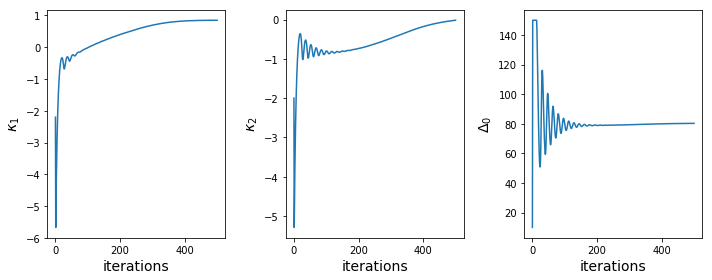

[ 5.33529677  7.31635234 11.43954115  0.19729214]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


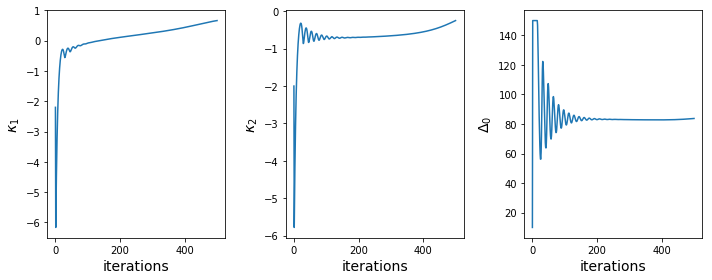

[ 5.37112289  6.47379071 14.93230054  0.20535236]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


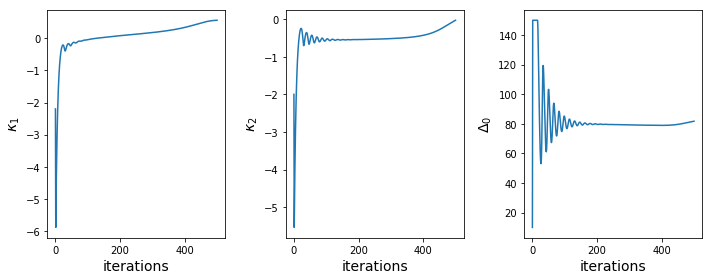

[4.14422113 7.08940518 4.62286826 0.09064709]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


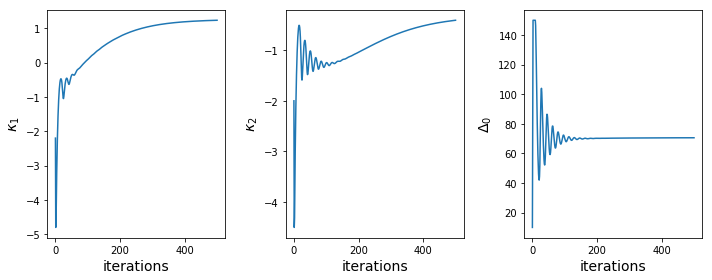

[ 3.5249731  13.00515098 37.513004    0.21434649]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


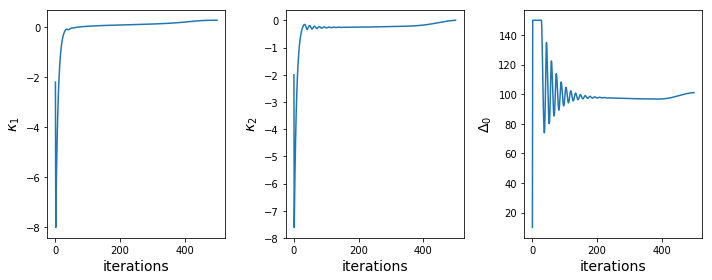

[3.46479123 8.44971491 2.2747374  0.03690608]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


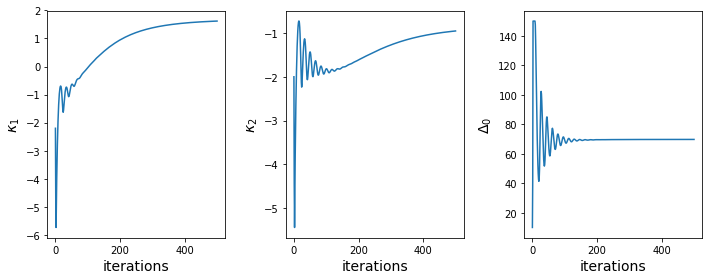

[ 3.40254238 10.1589342   0.64982046  0.0666721 ]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


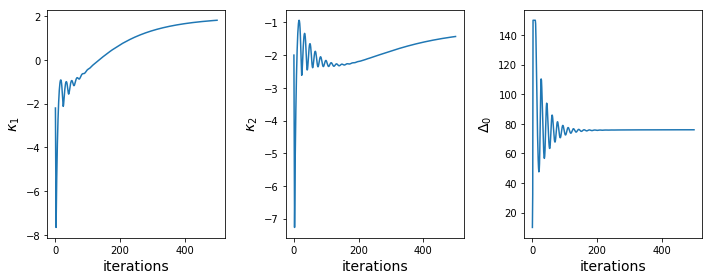

[ 3.06719839 10.33595981  6.58773415  0.21289477]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


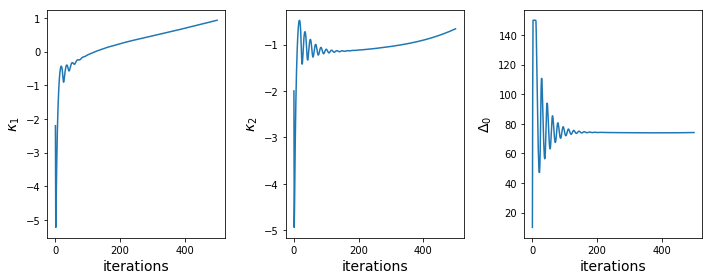

[6.06822321 4.97457669 3.94030912 0.10219158]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


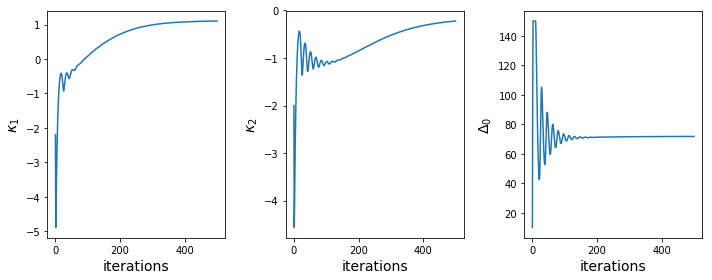

[ 2.81106971 11.4770961   2.08088865  0.09529692]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


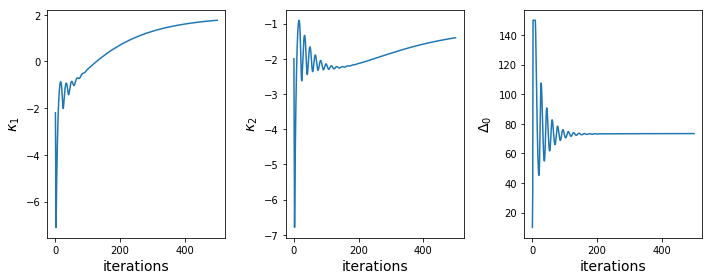

[ 2.70723892 10.07949715  4.66641439  0.26901894]


/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


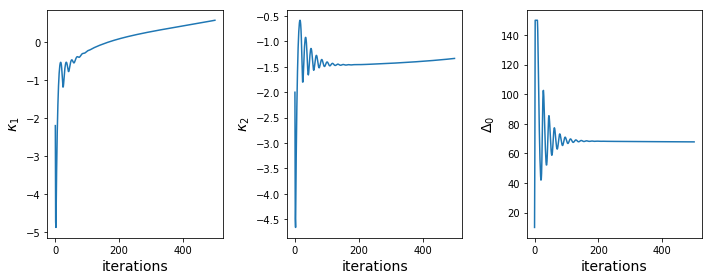

In [11]:
fontsize = 14
ii = 1
jj = 0
#beta_inds = np.logical_and(_betam > 0.0, _betan > 0.0)
plot_inds = kappa2_diffs[0,ii,jj,:] > 0.0006

#plot_inds = np.logical_and(beta_inds, diff_inds)
eps_ind = 0
for n_i in range(1000):
    if plot_inds[n_i]:
        print(params[n_i])
        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1)
        plt.plot(kappa1s[eps_ind,ii,jj,n_i,:])
        plt.xlabel('iterations', fontsize=fontsize)
        plt.ylabel(r'$\kappa_1$', fontsize=fontsize)
        plt.subplot(1,3,2)
        plt.plot(kappa2s[eps_ind,ii,jj,n_i,:])
        plt.xlabel('iterations', fontsize=fontsize)
        plt.ylabel(r'$\kappa_2$', fontsize=fontsize)
        plt.subplot(1,3,2)
        plt.subplot(1,3,3)
        plt.plot(delta_0s[eps_ind,ii,jj,n_i,:])
        plt.xlabel('iterations', fontsize=fontsize)
        plt.ylabel(r'$\Delta_0$', fontsize=fontsize)
        plt.tight_layout()
        plt.show()
    

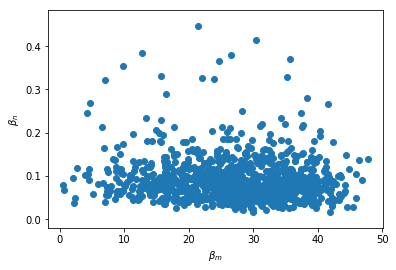

In [25]:
plt.figure()
plt.scatter(_betam, _betan)
plt.xlabel(r'$\beta_m$')
plt.ylabel(r'$\beta_n$')
plt.show()

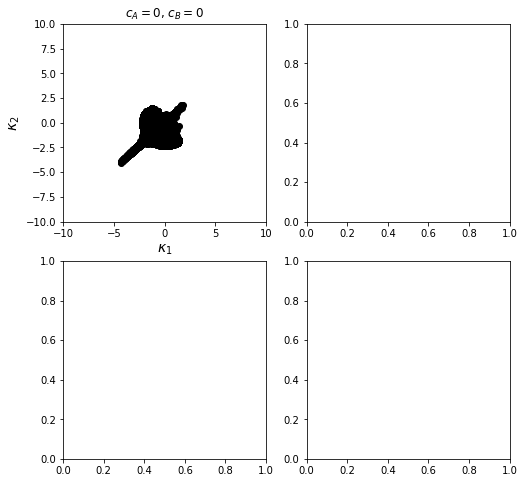

In [ ]:
colors = ['k', 'r', 'b', 'g']

labels = []
fontsize = 14
fig, axs = plt.subplots(2, 2, figsize=(8,8))
for i in range(num_cAs):
    cA = cAs[i]
    for j in range(num_cBs):
        cB = cBs[j]
        title = r'$c_A = %d$, $c_B = %d$' % (cA, cB)
        labels.append(title)
        axs[i,j].scatter(kappa1s[i,j], kappa2s[i,j], c=colors[2*i+j])
        axs[i,j].set_xlabel(r'$\kappa_1$', fontsize=fontsize)
        axs[i,j].set_ylabel(r'$\kappa_2$', fontsize=fontsize)
        axs[i,j].set_title(title)
        axs[i,j].set_xlim([-10,10])
        axs[i,j].set_ylim([-10, 10])
plt.show()

In [ ]:
plt.figure()
for i in range(num_cAs):
    cA = cAs[i]
    for j in range(num_cBs):
        cB = cBs[j]
        ind = 2*i + j
        plt.hist(zs[i,j,:], FaceColor=colors[ind], label=labels[ind])
plt.legend()
plt.show()

In [67]:
Zs = np.expand_dims(zs, 3)
print(Zs[0,0,:,:].shape)

(1000, 1)


In [68]:
Z = np.concatenate((Zs[0,0], Zs[0,1], Zs[1,0], Zs[1,1]), axis=1)

In [70]:
inds_low = np.logical_and(Z[:,0] < 0, Z[:,3] < 0)
inds_high = np.logical_and(Z[:,1] > 0, Z[:,2] > 0)
inds = np.logical_and(inds_low, inds_high)

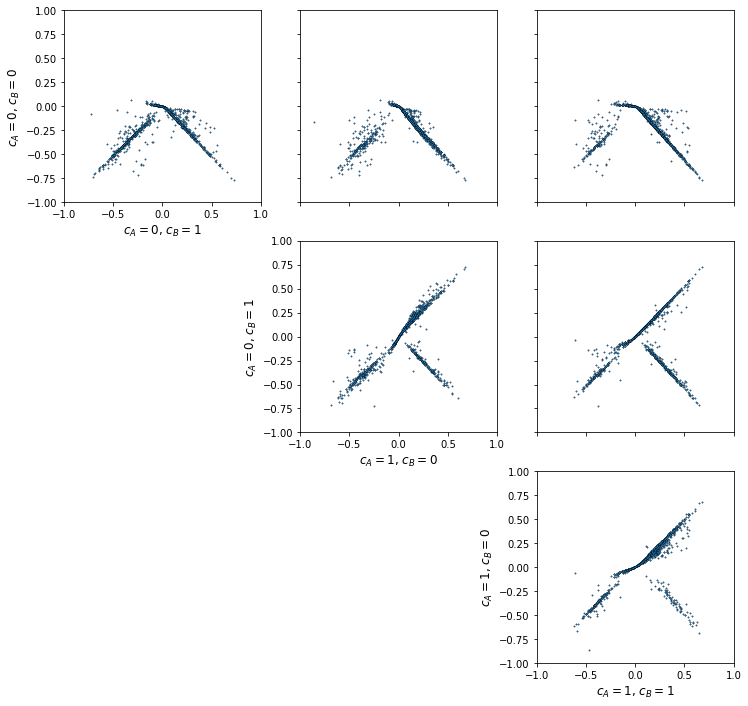

In [71]:
fig = pairplot(Z, range(4), labels, xlims=[-1, 1], ylims=[-1, 1])

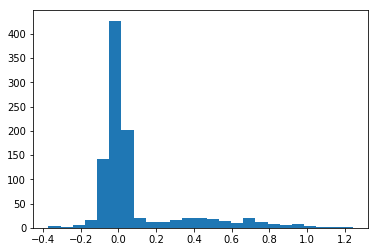

In [72]:
diffs = Zs[1,0] - Zs[0,1]
plt.figure()
plt.hist(diffs, 25)
plt.show()

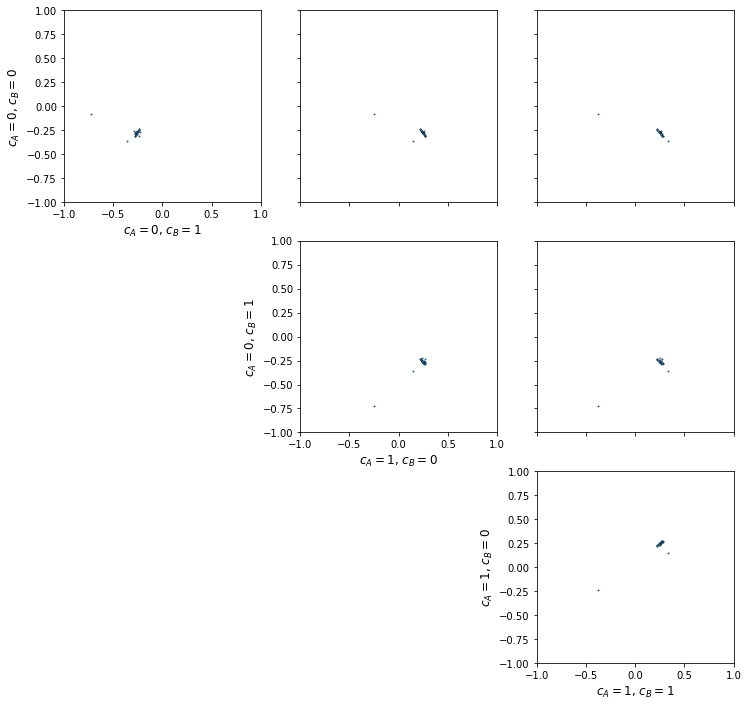

In [73]:

inds_low = diffs[:,0] > .45
inds_high = diffs[:,0] < .55
inds = np.logical_and(inds_low, inds_high)
fig = pairplot(Z[inds,:], range(4), labels, xlims=[-1, 1], ylims=[-1, 1])

(1000, 4)


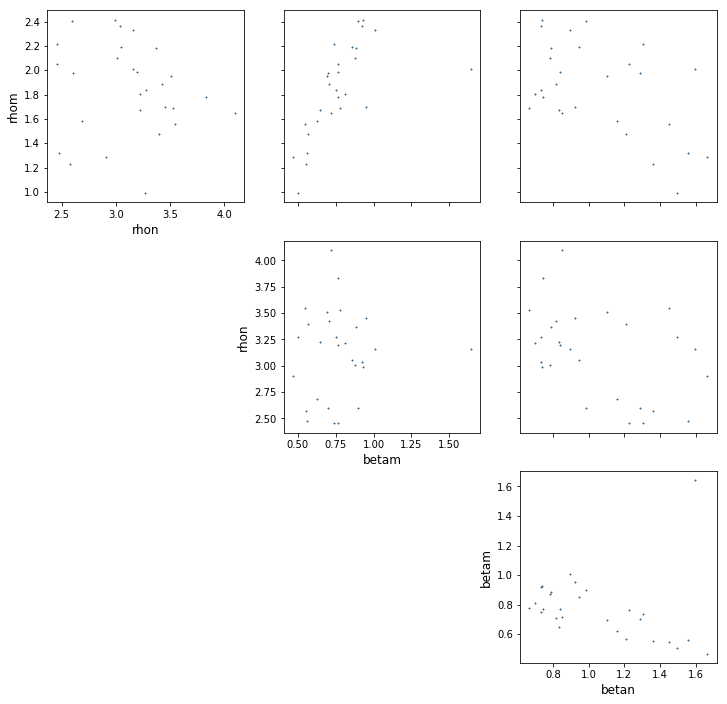

In [75]:
labels = ['rhom', 'rhon', 'betam', 'betan']
params = np.stack([_rhom, _rhon, _betam, _betan], axis=1)
print(params.shape)
fig = pairplot(params[inds,:], range(4), labels)

In [ ]:
rhom_xor = _rhom[inds]
rhon_xor = _rhon[inds]
betam_xor = _betam[inds]
betan_xor = _betan[inds]

print('rhom', rhom_xor)
print('rhon', rhon_xor)
print('betam', betam_xor)
print('betan', betan_xor)

In [ ]:
rhom [-0.3268798   2.5901365  -1.68711999 -0.38818384]
rhon [2.9713917  0.52257611 0.94958786 2.39911416]
betam [-1.92686328 -2.04672375 -2.25092573 -1.91615091]
betan [3.99441331 4.63058834 1.38784615 2.35561441]

(array([ 1.,  0.,  2.,  2.,  1.,  1.,  3.,  2.,  2.,  4.,  1.,  5.,  1.,
         5.,  6.,  5.,  4.,  6.,  6.,  8., 12.,  8.,  6.,  9., 10.,  8.,
        12., 16., 13., 13., 13., 22., 17., 19., 13., 25., 31., 24., 27.,
        27., 28., 21., 20., 31., 20., 28., 27., 19., 24., 30., 18., 21.,
        18., 24., 20., 19., 29., 20., 14., 25., 10., 11., 13., 13.,  8.,
        15.,  6.,  8.,  7.,  8.,  6.,  6.,  5.,  8.,  3.,  2.,  2.,  5.,
         2.,  3.,  1.,  0.,  1.,  1.,  1.,  0.,  3.,  0.,  1.,  0.,  1.,
         2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-8.58622864, -8.39416424, -8.20209985, -8.01003545, -7.81797106,
        -7.62590666, -7.43384227, -7.24177787, -7.04971348, -6.85764908,
        -6.66558469, -6.47352029, -6.2814559 , -6.0893915 , -5.89732711,
        -5.70526272, -5.51319832, -5.32113393, -5.12906953, -4.93700514,
        -4.74494074, -4.55287635, -4.36081195, -4.16874756, -3.97668316,
        -3.78461877, -3.59255437, -3.40048998, -3.20842558, -3.016361

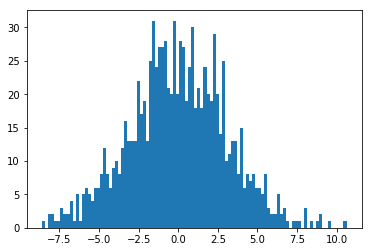

In [79]:
plt.hist(np.random.normal(0.0, 3.0, (1000)), 100)